In [1]:
!tar -xzvf "/content/drive/MyDrive/네이버 부스트캠프/STS_Competition/data.tar.gz"

._.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
./
./._test.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./test.csv
./._dev.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./dev.csv
./._train.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./train.csv
./._sample_submission.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./sample_submission.csv


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.1 MB/s 
     |████████████████████████████████| 163 kB 48.5 MB/s 
     |████████████████████████████████| 7.6 MB 37.4 MB/s 


In [8]:
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer

/opt/conda/envs/sts/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir("/opt/ml")

# 사용자 함수 정의

In [47]:
# 입력의 두 문장을 토크나이징하여 길이와 unk 토큰의 개수를 분석합니다
def tokenizing(df):
    tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')

    sentence1_len = []
    sentence2_len = []
    sentence1_unk = []
    sentence2_unk = []
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']

        sentence1_len.append(len(sentence1))
        sentence2_len.append(len(sentence2))

        sentence1_unk.append(sentence1.count(tokenizer.unk_token_id))
        sentence2_unk.append(sentence2.count(tokenizer.unk_token_id))

    tokenized_df = pd.DataFrame([sentence1_len, sentence2_len, sentence1_unk, sentence2_unk]).transpose()
    tokenized_df.columns = ['1_len', '2_len', '1_unk', '2_unk']
    print(tokenized_df.describe())

In [48]:
# label의 분포를 box plot으로 그립니다
def draw_box_plot(df):
    label_list = [row['label'] for i, row in df.iterrows()]

    plt.boxplot(label_list)
    plt.title("Boxplot for target label")
    plt.show()

In [49]:
# pandas 데이터를 가지고 그래프를 그리는 함수입니다
def draw_graph(df):
    source_binary = {source:[0, 0] for source in sorted(df['source'].unique())}
    for i, item in df.iterrows():
        source_binary[item['source']][int(item['binary-label'])] += 1
    source_binary_df = pd.DataFrame(source_binary).transpose()

    # source의 분포
    df['source'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # source별 binary label의 분포
    source_binary_df.plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # label의 분포
    df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
    plt.show()
    # binary label의 분포
    df['binary-label'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()

# 데이터 분석

In [45]:
# 데이터 읽기
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
sub_df = pd.read_csv("./data/sample_submission.csv")

In [50]:
train_df.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [11]:
test_df.head()

,id,source,sentence_1,sentence_2
0,boostcamp-sts-v1-test-000,petition-sampled,가상화폐거래소 폐쇄하지 말고,가상화폐 거래소 폐쇄 반대합니다
1,boostcamp-sts-v1-test-001,petition-sampled,뇌물적폐1호 640만달라 70억 뇌물받은 권양숙 구속하고 재산을 몰수하라,뇌물적폐 원조 640만달라 70억 뇌물받은 권양숙 구속하고 재산을 몰수하세요
2,boostcamp-sts-v1-test-002,petition-rtt,기무사 영관급의 하극상 정말 이대로 방관하는게 민주주의 인지요,그냥 가만히 있는게 진짜 민주주의인가요?
3,boostcamp-sts-v1-test-003,nsmc-sampled,화까지가 한계였다.,기대가 너무 컸다...
4,boostcamp-sts-v1-test-004,slack-rtt,왜 혼자 있지.. ㅠㅠ,왜 혼자야.. ㅠㅠ


In [9]:
sub_df.head()

,id,target
0,boostcamp-sts-v1-test-000,3.5
1,boostcamp-sts-v1-test-001,2.1
2,boostcamp-sts-v1-test-002,2.3
3,boostcamp-sts-v1-test-003,1.0
4,boostcamp-sts-v1-test-004,4.0


In [18]:
# label과 binary label 통계 분석
print(train_df.describe())

             label  binary-label
count  9324.000000   9324.000000
mean      1.849968      0.389532
std       1.602212      0.487670
min       0.000000      0.000000
25%       0.200000      0.000000
50%       1.600000      0.000000
75%       3.400000      1.000000
max       5.000000      1.000000


train


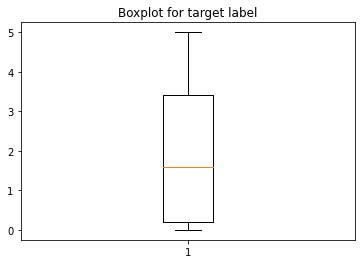

In [17]:
# label 분포 확인
print("train")
draw_box_plot(train_df)

In [22]:
# 토크나이징 결과 분석
print("train")
tokenizing(train_df)

train
             1_len        2_len        1_unk        2_unk
count  9324.000000  9324.000000  9324.000000  9324.000000
mean     14.848241    14.958387     0.028958     0.022308
std       7.771558     7.201888     0.179438     0.156163
min       3.000000     3.000000     0.000000     0.000000
25%      10.000000    10.000000     0.000000     0.000000
50%      13.000000    13.000000     0.000000     0.000000
75%      17.000000    18.000000     0.000000     0.000000
max      88.000000    84.000000     4.000000     2.000000


In [22]:
# source 종류 파악
print(f"train source unique : {sorted(train_df['source'].unique())}")

train source unique : ['nsmc-rtt', 'nsmc-sampled', 'petition-rtt', 'petition-sampled', 'slack-rtt', 'slack-sampled']


In [23]:
# pandas 데이터를 가지고 그래프를 그리는 함수입니다
def draw_graph(df):
    source_binary = {source:[0, 0] for source in sorted(df['source'].unique())}
    for i, item in df.iterrows():
        source_binary[item['source']][item['binary-label']] += 1
    source_binary_df = pd.DataFrame(source_binary).transpose()

    # source의 분포
    df['source'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # source별 binary label의 분포
    source_binary_df.plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # label의 분포
    df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
    plt.show()
    # binary label의 분포
    df['binary_label'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()

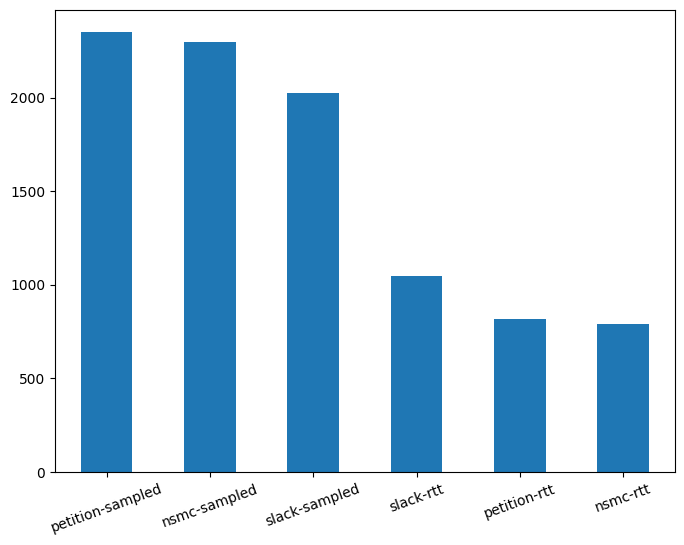

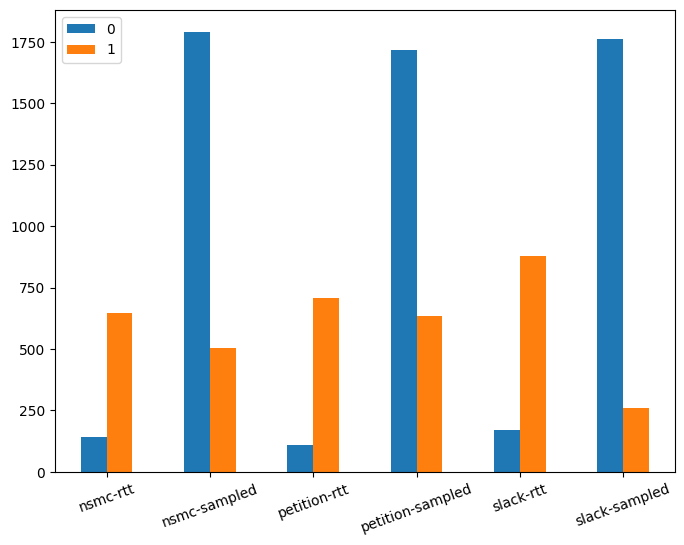

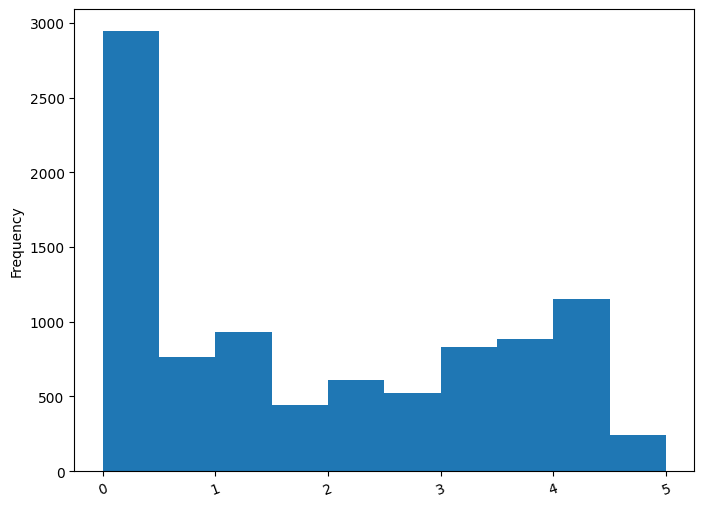

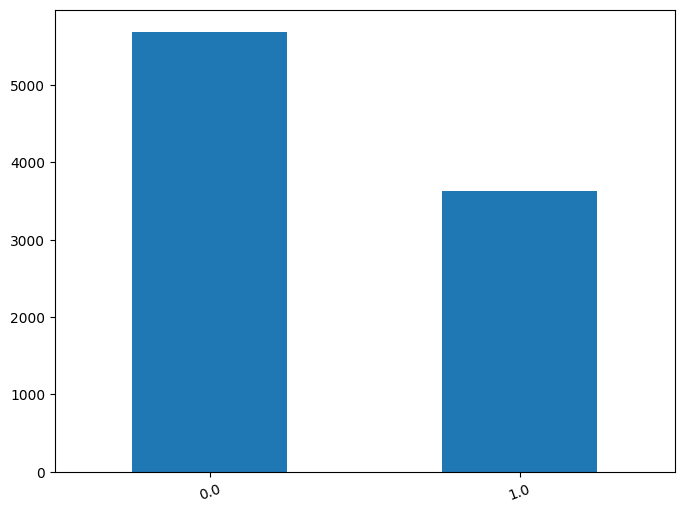

In [51]:
draw_graph(train_df)

# Back Translation + Copied Translation

## Back Translation

In [3]:
import pandas as pd
import os

os.chdir("/opt/ml")

In [7]:
df = pd.read_csv("/opt/ml/data/train.csv")
print(df.shape)
df.head()

(9324, 6)


,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [10]:
df.iloc[:,:2]

,id,source
0,boostcamp-sts-v1-train-000,nsmc-sampled
1,boostcamp-sts-v1-train-001,slack-rtt
2,boostcamp-sts-v1-train-002,petition-sampled
3,boostcamp-sts-v1-train-003,slack-sampled
4,boostcamp-sts-v1-train-004,slack-sampled
...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled
9320,boostcamp-sts-v1-train-9320,petition-sampled
9321,boostcamp-sts-v1-train-9321,petition-sampled
9322,boostcamp-sts-v1-train-9322,slack-sampled


In [11]:
df.iloc[:,-2:]

,label,binary-label
0,2.2,0.0
1,4.2,1.0
2,2.4,0.0
3,3.0,1.0
4,0.0,0.0
...,...,...
9319,0.2,0.0
9320,4.2,1.0
9321,0.6,0.0
9322,3.2,1.0


In [8]:
s1 = pd.read_csv("/opt/ml/data/train_data_pororo_sent1.csv")
print(s1.shape)
s1.head()

(9324, 1)


,sentence_1
0,"스릴링, 반전, 다른 어떤 한국 영화 쓰레기와도 다르다."
1,"아, 저는 접근권이 없다고 합니다."
2,주택 신청 조건을 바꿔라
3,입사 후 처음으로 만나서 반가웠다.
4,자존심이 가득해!


In [9]:
s2 = pd.read_csv("/opt/ml/data/train_data_pororo_sent2.csv")
print(s2.shape)
s2.head()

(9324, 1)


,sentence_2
0,"반전, 사랑, 재미가 있다"
1,"아, 난 접근권이 없어."
2,주택 청약이 없는 기준을 변경한다
3,영상만으로도 실생활에서 보니 정말 반가웠다.
4,"사실, 너를 한 번 봤어!"


In [6]:
df.concat()

(9324, 1)

In [19]:
b_df = pd.concat([df.iloc[:,:2],s1,s2,df.iloc[:,-2:]], axis=1)
b_df.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"스릴링, 반전, 다른 어떤 한국 영화 쓰레기와도 다르다.","반전, 사랑, 재미가 있다",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,"아, 저는 접근권이 없다고 합니다.","아, 난 접근권이 없어.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택 신청 조건을 바꿔라,주택 청약이 없는 기준을 변경한다,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음으로 만나서 반가웠다.,영상만으로도 실생활에서 보니 정말 반가웠다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,자존심이 가득해!,"사실, 너를 한 번 봤어!",0.0,0.0


In [20]:
b_df.sample(frac=0.5, random_state=100)

,id,source,sentence_1,sentence_2,label,binary-label
1621,boostcamp-sts-v1-train-1621,nsmc-rtt,그 대본과 시나리오에 대해 죄송합니다,그 시나리오를 쓴 사람에게 미안하다,2.0,0.0
7131,boostcamp-sts-v1-train-7131,nsmc-sampled,두려움이나 긴장은 전혀 없다,긴장감이 별로 없다,3.0,1.0
2671,boostcamp-sts-v1-train-2671,petition-sampled,조두순의 석방에 대한 청원,조두순의 석방에 반대하는 청원이 나왔다.,4.2,1.0
2917,boostcamp-sts-v1-train-2917,slack-rtt,오늘부터 하루 식사를 할 거야 가! 가!,이는 오늘부터 하루밖에 안 남았다 가! 가!,1.6,0.0
3331,boostcamp-sts-v1-train-3331,petition-rtt,스포츠 홍보 투표권과 문화체육관광부 진상규명 등을 위한 청원서,문화체육관광부에서 스포츠 홍보 투표권 침해 청원과 사보타 주에 대한 조사,1.8,0.0
...,...,...,...,...,...,...
2052,boostcamp-sts-v1-train-2052,nsmc-sampled,프랑스 영화를 방해하는 영화,적어도 재미있는 영화,2.4,0.0
3345,boostcamp-sts-v1-train-3345,nsmc-rtt,"이러한 고대,복고기능 촬영 기법이 만들어낸 전통적인 한국 에로티즘을 벗어나 유로 영...",이런 고풍스럽고 복고적인 촬영 기법으로 만들어진 한국의 전통적인 에로티즘은 유로 영...,3.6,1.0
4070,boostcamp-sts-v1-train-4070,petition-sampled,중학생 7시간,5월 10일 한 부모의 날,0.0,0.0
6576,boostcamp-sts-v1-train-6576,slack-sampled,금요일 잘 보내세요!,진차의 귀여운 아이와 일주일을 시작해!,0.0,0.0


In [22]:
b05_df = pd.concat([df,b_df.sample(frac=0.5, random_state=100)], axis=0)
b05_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
2052,boostcamp-sts-v1-train-2052,nsmc-sampled,프랑스 영화를 방해하는 영화,적어도 재미있는 영화,2.4,0.0
3345,boostcamp-sts-v1-train-3345,nsmc-rtt,"이러한 고대,복고기능 촬영 기법이 만들어낸 전통적인 한국 에로티즘을 벗어나 유로 영...",이런 고풍스럽고 복고적인 촬영 기법으로 만들어진 한국의 전통적인 에로티즘은 유로 영...,3.6,1.0
4070,boostcamp-sts-v1-train-4070,petition-sampled,중학생 7시간,5월 10일 한 부모의 날,0.0,0.0
6576,boostcamp-sts-v1-train-6576,slack-sampled,금요일 잘 보내세요!,진차의 귀여운 아이와 일주일을 시작해!,0.0,0.0


In [24]:
b05_df.iloc[9324:,:]

,id,source,sentence_1,sentence_2,label,binary-label
1621,boostcamp-sts-v1-train-1621,nsmc-rtt,그 대본과 시나리오에 대해 죄송합니다,그 시나리오를 쓴 사람에게 미안하다,2.0,0.0
7131,boostcamp-sts-v1-train-7131,nsmc-sampled,두려움이나 긴장은 전혀 없다,긴장감이 별로 없다,3.0,1.0
2671,boostcamp-sts-v1-train-2671,petition-sampled,조두순의 석방에 대한 청원,조두순의 석방에 반대하는 청원이 나왔다.,4.2,1.0
2917,boostcamp-sts-v1-train-2917,slack-rtt,오늘부터 하루 식사를 할 거야 가! 가!,이는 오늘부터 하루밖에 안 남았다 가! 가!,1.6,0.0
3331,boostcamp-sts-v1-train-3331,petition-rtt,스포츠 홍보 투표권과 문화체육관광부 진상규명 등을 위한 청원서,문화체육관광부에서 스포츠 홍보 투표권 침해 청원과 사보타 주에 대한 조사,1.8,0.0
...,...,...,...,...,...,...
2052,boostcamp-sts-v1-train-2052,nsmc-sampled,프랑스 영화를 방해하는 영화,적어도 재미있는 영화,2.4,0.0
3345,boostcamp-sts-v1-train-3345,nsmc-rtt,"이러한 고대,복고기능 촬영 기법이 만들어낸 전통적인 한국 에로티즘을 벗어나 유로 영...",이런 고풍스럽고 복고적인 촬영 기법으로 만들어진 한국의 전통적인 에로티즘은 유로 영...,3.6,1.0
4070,boostcamp-sts-v1-train-4070,petition-sampled,중학생 7시간,5월 10일 한 부모의 날,0.0,0.0
6576,boostcamp-sts-v1-train-6576,slack-sampled,금요일 잘 보내세요!,진차의 귀여운 아이와 일주일을 시작해!,0.0,0.0


In [37]:
address = '/opt/ml/data/'

In [34]:
b05_df.to_csv(path_or_buf=address+'b05_df.csv', index=False)

In [37]:
b033_df = pd.concat([df,b_df.sample(frac=0.33, random_state=100)], axis=0)
b033_df.to_csv(path_or_buf=address+'b033_df.csv', index=False)

In [40]:
b025_df = pd.concat([df,b_df.sample(frac=0.25, random_state=100)], axis=0)
b025_df.to_csv(path_or_buf=address+'b025_df.csv', index=False)
b066_df = pd.concat([df,b_df.sample(frac=0.66, random_state=100)], axis=0)
b066_df.to_csv(path_or_buf=address+'b066_df.csv', index=False)
b075_df = pd.concat([df,b_df.sample(frac=0.75, random_state=100)], axis=0)
b075_df.to_csv(path_or_buf=address+'b075_df.csv', index=False)

In [49]:
b025_df.shape

(11655, 6)

In [50]:
9324 +2331

11655

In [41]:
b04_df = pd.concat([df,b_df.sample(frac=0.4, random_state=100)], axis=0)
b04_df.to_csv(path_or_buf=address+'b04_df.csv', index=False)
b03_df = pd.concat([df,b_df.sample(frac=0.3, random_state=100)], axis=0)
b03_df.to_csv(path_or_buf=address+'b03_df.csv', index=False)
b02_df = pd.concat([df,b_df.sample(frac=0.2, random_state=100)], axis=0)
b02_df.to_csv(path_or_buf=address+'b02_df.csv', index=False)
b01_df = pd.concat([df,b_df.sample(frac=0.1, random_state=100)], axis=0)
b01_df.to_csv(path_or_buf=address+'b01_df.csv', index=False)

In [11]:
not5_df = df.loc[df['label']!=5.0]
not5_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,3.2,1.0


In [53]:
tmp = not5_df.sample(n=2331, random_state=100)

In [62]:
label5 = pd.DataFrame({'label':[5.0]*2331,'binary-label':[1.0]*2331})

In [66]:
label5

,label,binary-label
0,5.0,1.0
1,5.0,1.0
2,5.0,1.0
3,5.0,1.0
4,5.0,1.0
...,...,...
2326,5.0,1.0
2327,5.0,1.0
2328,5.0,1.0
2329,5.0,1.0


In [75]:
pd.concat([pd.concat([tmp.iloc[:,:3],tmp.iloc[:,2]], axis=1).reset_index().iloc[:,1:],label5],axis=1)

,id,source,sentence_1,sentence_1,label,binary-label
0,boostcamp-sts-v1-train-4918,nsmc-sampled,허나 불륜아닙니까?,허나 불륜아닙니까?,5.0,1.0
1,boostcamp-sts-v1-train-8763,nsmc-rtt,어쩐지//옛날영화처럼느껴지네요,어쩐지//옛날영화처럼느껴지네요,5.0,1.0
2,boostcamp-sts-v1-train-3750,petition-sampled,공인중개사 자격시험 제도개선 방안수립요청,공인중개사 자격시험 제도개선 방안수립요청,5.0,1.0
3,boostcamp-sts-v1-train-3539,nsmc-sampled,스토리가 분산되지 않았으면 훨씬 더 좋았을텐데..,스토리가 분산되지 않았으면 훨씬 더 좋았을텐데..,5.0,1.0
4,boostcamp-sts-v1-train-2529,petition-sampled,유튜브 가짜 뉴스를 관리해 주십시오,유튜브 가짜 뉴스를 관리해 주십시오,5.0,1.0
...,...,...,...,...,...,...
2326,boostcamp-sts-v1-train-6802,slack-rtt,요리가 다 너무 맛있어 보여서 배고파지네요,요리가 다 너무 맛있어 보여서 배고파지네요,5.0,1.0
2327,boostcamp-sts-v1-train-4180,slack-rtt,오.. 윙스팬 하시게된다면 말씀해주세요 ㅋㅋ,오.. 윙스팬 하시게된다면 말씀해주세요 ㅋㅋ,5.0,1.0
2328,boostcamp-sts-v1-train-6633,petition-sampled,정부는 서울만 보이시나요?,정부는 서울만 보이시나요?,5.0,1.0
2329,boostcamp-sts-v1-train-4940,nsmc-sampled,저도 평점에 낚여서 본 사람..,저도 평점에 낚여서 본 사람..,5.0,1.0


In [78]:
not5_025_df = pd.concat([pd.concat([tmp.iloc[:,:3],tmp.iloc[:,2]], axis=1).reset_index().iloc[:,1:],label5],axis=1)

In [84]:
b025_df = b025_df.reset_index().iloc[:,1:]

In [94]:
b025_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11650,boostcamp-sts-v1-train-2489,nsmc-sampled,문화가 뭐야? 판타지 여행? 내가 담당할 때 나는 문화에 가깝다,무한정서적인 무비가 불가능하게 만들었다!,0.0,0.0
11651,boostcamp-sts-v1-train-2047,petition-sampled,소비일을 표시해 주십시오,일본 전범기에 대한 공식 항의를 부탁드립니다.,0.0,0.0
11652,boostcamp-sts-v1-train-974,petition-sampled,나는 깨끗한 해변을 청원한다,우리는 소통을 위한 국민청원 방식 개정을 요청한다,0.5,0.0
11653,boostcamp-sts-v1-train-4937,slack-rtt,당신은 내년 초에 받을 예정이었다,원래 내년 초에 접수될 예정이었다.,3.8,1.0


In [90]:
not5_025_df = not5_025_df.reset_index().iloc[:,1:]

In [ ]:
not5_025_df[s1] = not5_025_df[s2]

In [93]:
not5_025_df

,id,source,sentence_1,sentence_1,label,binary-label
0,boostcamp-sts-v1-train-4918,nsmc-sampled,허나 불륜아닙니까?,허나 불륜아닙니까?,5.0,1.0
1,boostcamp-sts-v1-train-8763,nsmc-rtt,어쩐지//옛날영화처럼느껴지네요,어쩐지//옛날영화처럼느껴지네요,5.0,1.0
2,boostcamp-sts-v1-train-3750,petition-sampled,공인중개사 자격시험 제도개선 방안수립요청,공인중개사 자격시험 제도개선 방안수립요청,5.0,1.0
3,boostcamp-sts-v1-train-3539,nsmc-sampled,스토리가 분산되지 않았으면 훨씬 더 좋았을텐데..,스토리가 분산되지 않았으면 훨씬 더 좋았을텐데..,5.0,1.0
4,boostcamp-sts-v1-train-2529,petition-sampled,유튜브 가짜 뉴스를 관리해 주십시오,유튜브 가짜 뉴스를 관리해 주십시오,5.0,1.0
...,...,...,...,...,...,...
2326,boostcamp-sts-v1-train-6802,slack-rtt,요리가 다 너무 맛있어 보여서 배고파지네요,요리가 다 너무 맛있어 보여서 배고파지네요,5.0,1.0
2327,boostcamp-sts-v1-train-4180,slack-rtt,오.. 윙스팬 하시게된다면 말씀해주세요 ㅋㅋ,오.. 윙스팬 하시게된다면 말씀해주세요 ㅋㅋ,5.0,1.0
2328,boostcamp-sts-v1-train-6633,petition-sampled,정부는 서울만 보이시나요?,정부는 서울만 보이시나요?,5.0,1.0
2329,boostcamp-sts-v1-train-4940,nsmc-sampled,저도 평점에 낚여서 본 사람..,저도 평점에 낚여서 본 사람..,5.0,1.0


In [98]:
pd.concat([b025_df,not5_025_df], ignore_index=True).reindex(b025_df.columns, axis='columns')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [99]:
b025_df.append(not5_025_df)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [9]:
df = pd.read_csv("./data/train.csv")

In [10]:
df.loc[df['label']==5.0]

,id,source,sentence_1,sentence_2,label,binary-label
342,boostcamp-sts-v1-train-342,petition-rtt,정형식판사 감사요청,정형식 판사 감사요청,5.0,1.0
358,boostcamp-sts-v1-train-358,petition-sampled,이병박 출국금지 청원 합니다.,이명박 출국 금지 청원합니다.,5.0,1.0
448,boostcamp-sts-v1-train-448,petition-rtt,제주도 가정용lpg통가스보일러,제주도 가정용 LPG 통가스보일러,5.0,1.0
621,boostcamp-sts-v1-train-621,petition-sampled,청소년법 폐지 시켜주세요,청소년법 폐지 시켜 주세요,5.0,1.0
624,boostcamp-sts-v1-train-624,nsmc-rtt,"잔잔한 감동으로 다가온영화,","잔잔한 감동으로 다가온 영화,",5.0,1.0
...,...,...,...,...,...,...
9088,boostcamp-sts-v1-train-9088,nsmc-sampled,내인생최고의 드라마!!,내 인생 최고의 드라마!!!,5.0,1.0
9146,boostcamp-sts-v1-train-9146,petition-rtt,개인정보 보호법 개정을 촉구합니다.,개인정보보호법 개정을 촉구합니다.,5.0,1.0
9165,boostcamp-sts-v1-train-9165,slack-sampled,마음 따듯해지는 시간이었습니다.,마음 따뜻해지는 시간이었습니다.,5.0,1.0
9230,boostcamp-sts-v1-train-9230,slack-rtt,저도 참여할게요~!,저도 참여할게요!,5.0,1.0


In [31]:
tmp = not5_df.sample(frac=0.5, random_state=42)

In [32]:
tmp['label'] = 5.0
tmp['binary-label'] = 1.0
tmp['sentence_1'] = tmp['sentence_2']
tmp = tmp.reset_index().iloc[:,1:]

In [33]:
c_05_df = pd.concat([df,tmp]).reset_index().iloc[:,1:]
c_05_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
13935,boostcamp-sts-v1-train-826,petition-sampled,아시안게임 공동입장 및 단일팀 구성을 멈춰주세요.,아시안게임 공동입장 및 단일팀 구성을 멈춰주세요.,5.0,1.0
13936,boostcamp-sts-v1-train-4862,petition-sampled,크림하우스매트 조사해주세요~,크림하우스매트 조사해주세요~,5.0,1.0
13937,boostcamp-sts-v1-train-7224,slack-sampled,헐 저 낼 갑니닷!,헐 저 낼 갑니닷!,5.0,1.0
13938,boostcamp-sts-v1-train-5998,petition-sampled,공공시설.다중이용시설에 대한 소방관련아이디어,공공시설.다중이용시설에 대한 소방관련아이디어,5.0,1.0


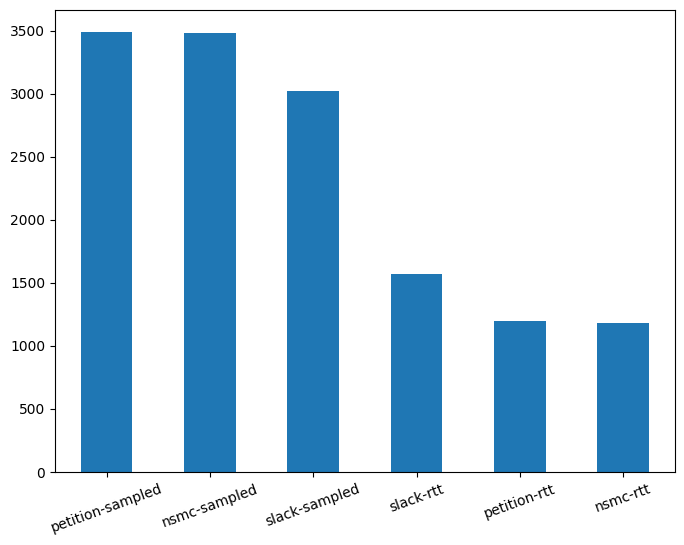

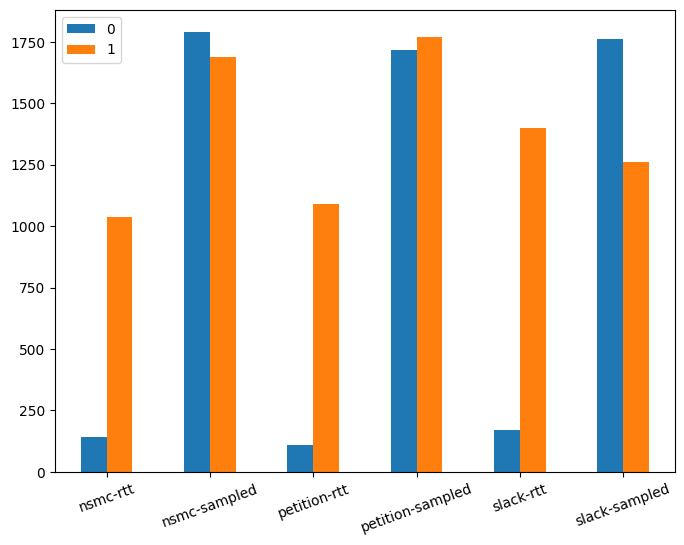

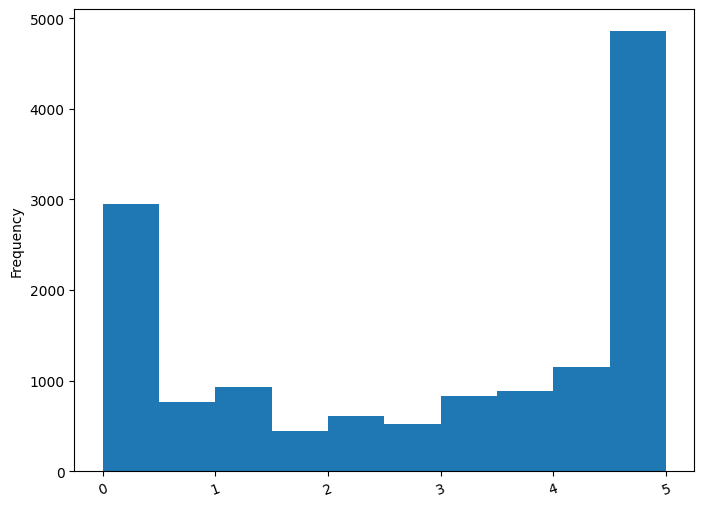

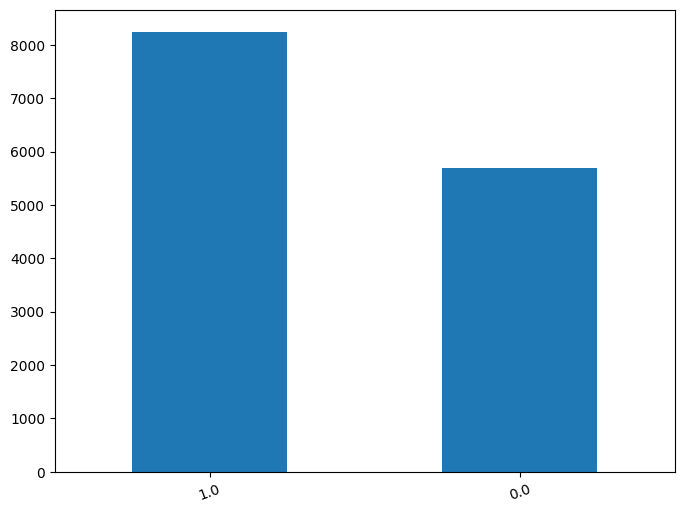

In [52]:
draw_graph(c_05_df)

In [37]:
print(c_05_df.describe())

              label  binary-label
count  13940.000000  13940.000000
mean       2.893049      0.591679
std        1.978599      0.491541
min        0.000000      0.000000
25%        0.800000      0.000000
50%        3.400000      1.000000
75%        5.000000      1.000000
max        5.000000      1.000000


In [39]:
c_05_df.to_csv(path_or_buf=address+'c_05_df.csv', index=False)

In [56]:
tmp = not5_df.sample(frac=0.25, random_state=42)
tmp['label'] = 5.0
tmp['binary-label'] = 1.0
tmp['sentence_1'] = tmp['sentence_2']
tmp = tmp.reset_index().iloc[:,1:]
c_025_df = pd.concat([df,tmp]).reset_index().iloc[:,1:]
c_025_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11627,boostcamp-sts-v1-train-647,nsmc-sampled,손발이 오글거려도 좋다 ~~~~,손발이 오글거려도 좋다 ~~~~,5.0,1.0
11628,boostcamp-sts-v1-train-176,petition-rtt,선거 운동 차량 소음 공해,선거 운동 차량 소음 공해,5.0,1.0
11629,boostcamp-sts-v1-train-9239,petition-sampled,청소년법 폐지하여 주십시오.,청소년법 폐지하여 주십시오.,5.0,1.0
11630,boostcamp-sts-v1-train-4016,nsmc-sampled,정말 재밌게 봤던 드라마.,정말 재밌게 봤던 드라마.,5.0,1.0


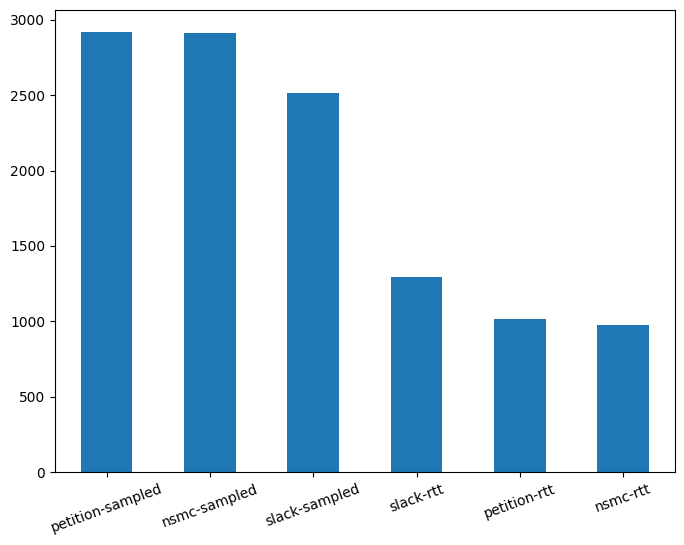

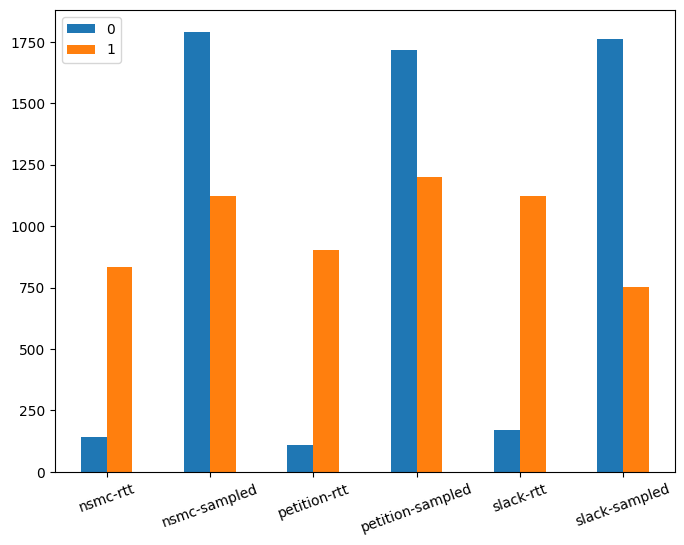

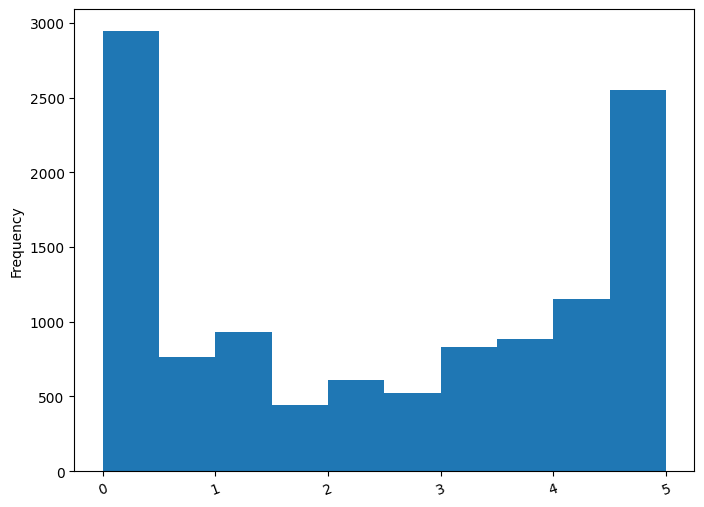

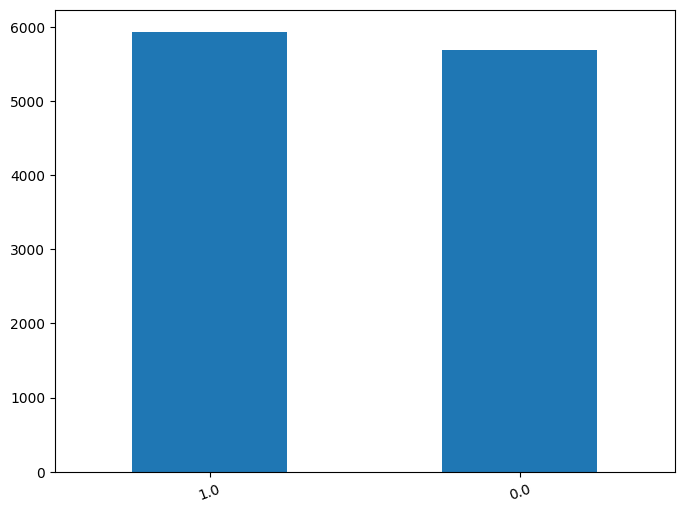

In [57]:
draw_graph(c_025_df)

In [58]:
print(c_025_df.describe())

              label  binary-label
count  11632.000000  11632.000000
mean       2.474991      0.510660
std        1.906833      0.499908
min        0.000000      0.000000
25%        0.400000      0.000000
50%        2.600000      1.000000
75%        4.200000      1.000000
max        5.000000      1.000000


In [59]:
c_025_df.to_csv(path_or_buf=address+'c_025_df.csv', index=False)

In [60]:
tmp = not5_df.sample(frac=0.2, random_state=42)
tmp['label'] = 5.0
tmp['binary-label'] = 1.0
tmp['sentence_1'] = tmp['sentence_2']
tmp = tmp.reset_index().iloc[:,1:]
c_02_df = pd.concat([df,tmp]).reset_index().iloc[:,1:]
c_02_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11166,boostcamp-sts-v1-train-3039,petition-sampled,아동 성폭력 처벌 강화해주세요,아동 성폭력 처벌 강화해주세요,5.0,1.0
11167,boostcamp-sts-v1-train-8336,petition-sampled,정형식 판사 특별감사 청원합니다,정형식 판사 특별감사 청원합니다,5.0,1.0
11168,boostcamp-sts-v1-train-4437,nsmc-sampled,저는 공감이 되는 영화 였습니다.,저는 공감이 되는 영화 였습니다.,5.0,1.0
11169,boostcamp-sts-v1-train-1744,slack-sampled,못다한 얘기 나눌 수 있는 기회가 꼭 다시 오면 좋겠습니다!,못다한 얘기 나눌 수 있는 기회가 꼭 다시 오면 좋겠습니다!,5.0,1.0


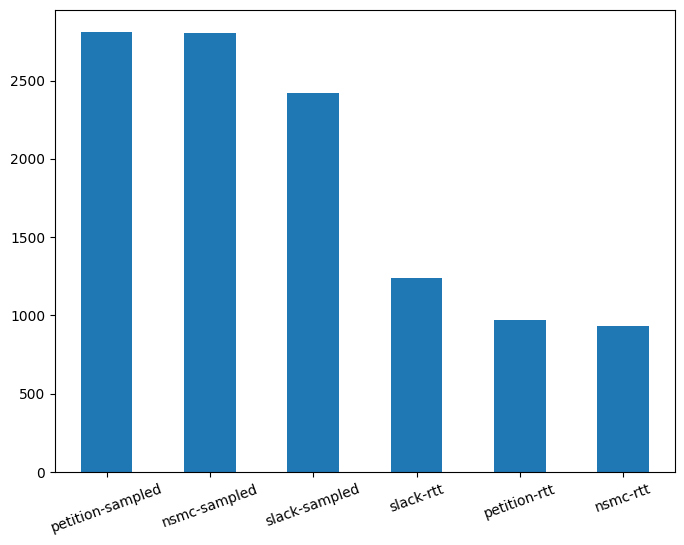

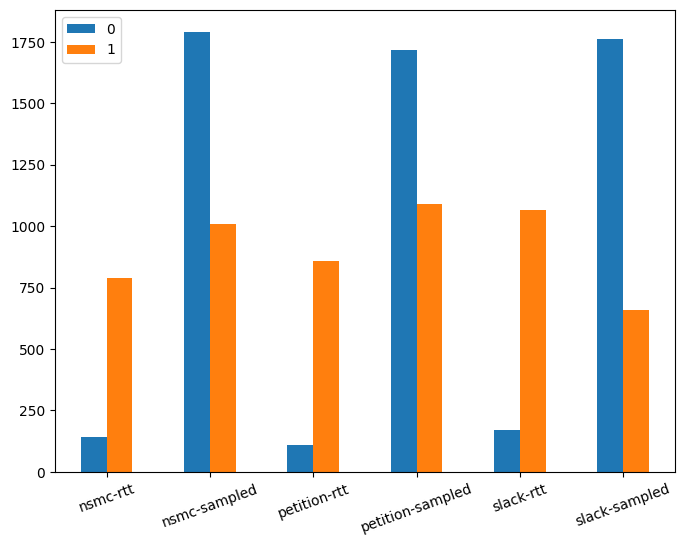

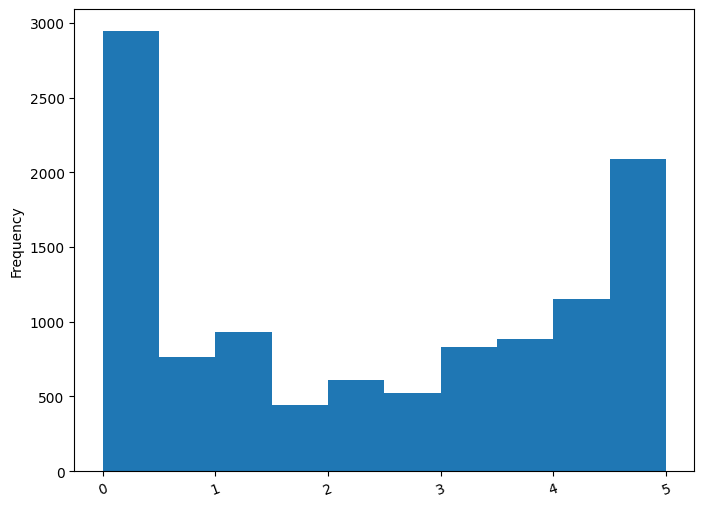

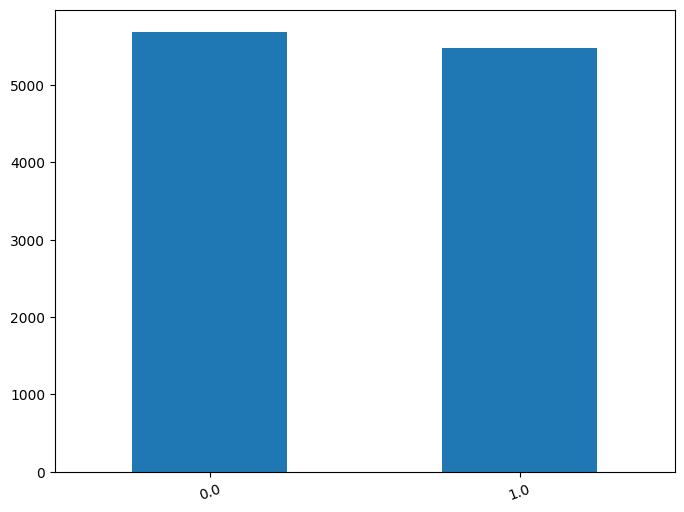

In [61]:
draw_graph(c_02_df)

In [62]:
c_02_df.to_csv(path_or_buf=address+'c_02_df.csv', index=False)

In [65]:
tmp = not5_df.sample(frac=0.1, random_state=42)
tmp['label'] = 5.0
tmp['binary-label'] = 1.0
tmp['sentence_1'] = tmp['sentence_2']
tmp = tmp.reset_index().iloc[:,1:]
c_01_df = pd.concat([df,tmp]).reset_index().iloc[:,1:]
c_01_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
10242,boostcamp-sts-v1-train-8714,petition-sampled,학교폭력 및 왕따 방지 대책 마련,학교폭력 및 왕따 방지 대책 마련,5.0,1.0
10243,boostcamp-sts-v1-train-8846,slack-sampled,저도 이건 먹기가 쉽지 않네요. ㅋㅋ,저도 이건 먹기가 쉽지 않네요. ㅋㅋ,5.0,1.0
10244,boostcamp-sts-v1-train-4930,slack-sampled,ㅋㅋ 사장님과 직원 같아요 ㅋㅋㅋ,ㅋㅋ 사장님과 직원 같아요 ㅋㅋㅋ,5.0,1.0
10245,boostcamp-sts-v1-train-5984,petition-rtt,국토부 장관! 투기 시작점을 중간 페널티로 벌해주세요!,국토부 장관! 투기 시작점을 중간 페널티로 벌해주세요!,5.0,1.0


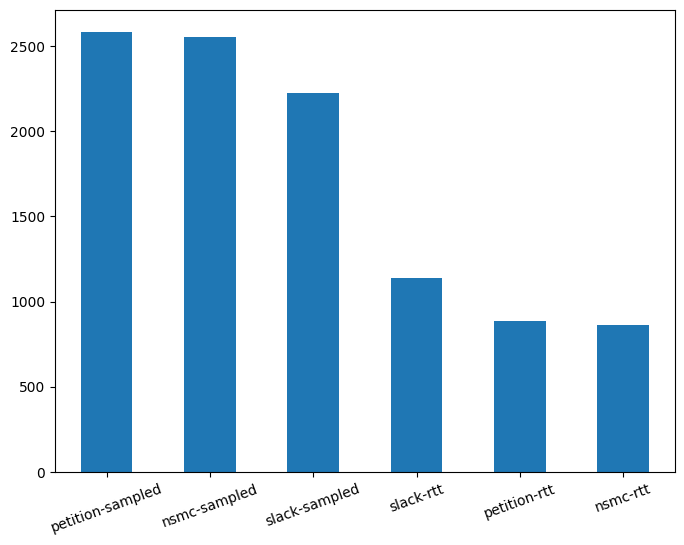

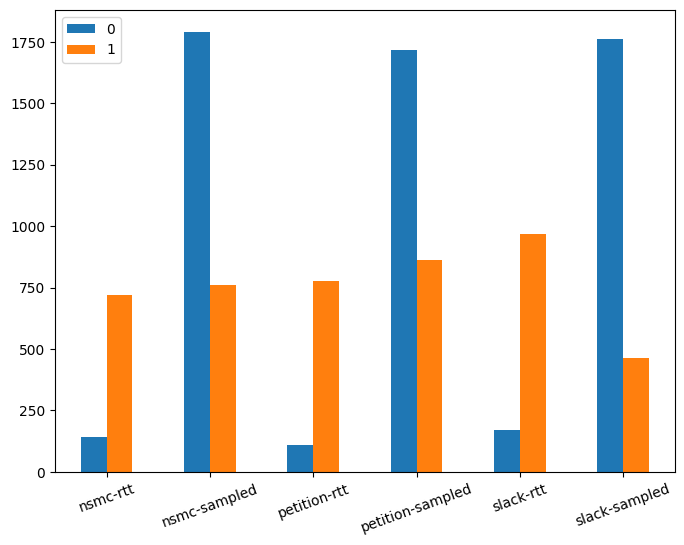

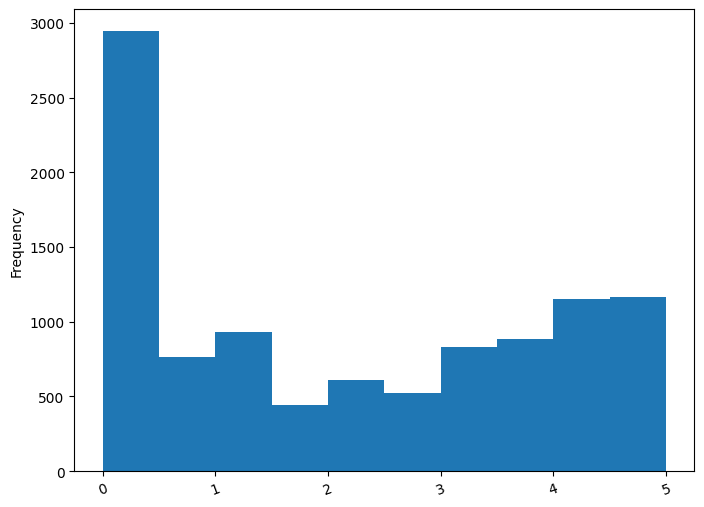

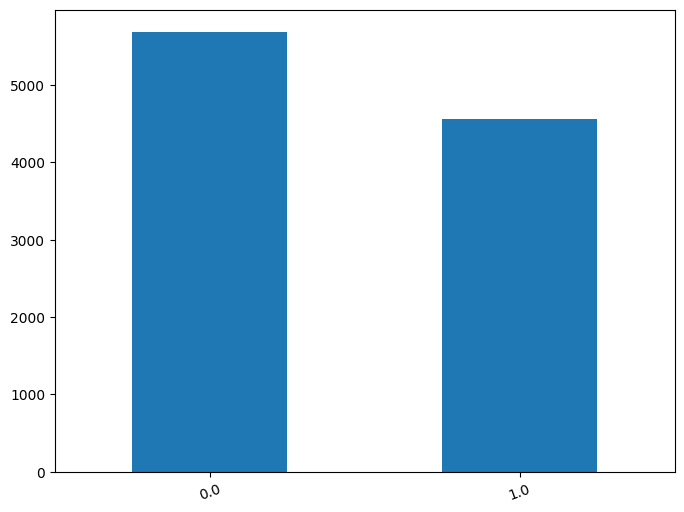

In [66]:
draw_graph(c_01_df)

In [67]:
c_01_df.to_csv(path_or_buf=address+'c_01_df.csv', index=False)

In [43]:
def reverse(txt):
    return ' '.join(txt.split()[::-1])

In [76]:
sample = df.sample(frac=0.5, random_state=42)
sample.sentence_1 = sample.sentence_1.apply(reverse)
sample.sentence_2 = sample.sentence_2.apply(reverse)
sample = sample.reset_index().iloc[:,1:]
r_05_df = pd.concat([df,sample]).reset_index().iloc[:,1:]
r_05_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
13981,boostcamp-sts-v1-train-5129,petition-sampled,삭감하라 전부 예산은 퍼주는 북한에,삭감하라 전부 예산 퍼주기식 북한에,4.6,1.0
13982,boostcamp-sts-v1-train-8360,petition-rtt,요청 처벌 언론사 관련 경우 아닐 사실이 청원 처벌 관련자 경우 들어날 사실로 감찰...,청원 달라는 처벌해 관련자 시 확인 사실 및 시찰 특혜 양주병원 국군 지드래곤 권지용,3.0,1.0
13983,boostcamp-sts-v1-train-1255,petition-sampled,개선 수준 서비스업,조절해주세요 근무시간 서비스업도,2.2,0.0
13984,boostcamp-sts-v1-train-2104,petition-sampled,청원 수사 댓글부대,청원 조사 전수 댓글부대,3.2,1.0


In [77]:
r_05_df.to_csv(path_or_buf=address+'r_05_df.csv', index=False)

In [74]:
sample = df.sample(frac=0.25, random_state=42)
sample.sentence_1 = sample.sentence_1.apply(reverse)
sample.sentence_2 = sample.sentence_2.apply(reverse)
sample = sample.reset_index().iloc[:,1:]
r_025_df = pd.concat([df,sample]).reset_index().iloc[:,1:]
r_025_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11650,boostcamp-sts-v1-train-1535,slack-sampled,가졌습니다~! 밥스테이지를 4월의 님과 <PERSON>,진행했습니다! 밥스테이지를 못한 하지 미처 3월달에 님과 <PERSON>,2.4,0.0
11651,boostcamp-sts-v1-train-6498,slack-sampled,분들은...링크 궁금하신 이유가,있어요!! 수 함께하실 여기서 분들은 궁금하신,2.0,0.0
11652,boostcamp-sts-v1-train-4965,slack-sampled,ㅎㅎ 진배없!! 해낸것과 이정도면 와,대대대박!! 초초초 와.,0.0,0.0
11653,boostcamp-sts-v1-train-3487,slack-rtt,여쭤봤습니다. 어떻겠냐고 되시는게 마스터가 스크럼 전사적 회사의 우리,물었다. 것인지 어떤 것이 되는 마스터가 스크럼 전사적 회사의 우리 나는,3.4,1.0


In [75]:
r_025_df.to_csv(path_or_buf=address+'r_025_df.csv', index=False)

In [70]:
sample = df.sample(frac=0.2, random_state=42)
sample.sentence_1 = sample.sentence_1.apply(reverse)
sample.sentence_2 = sample.sentence_2.apply(reverse)
sample = sample.reset_index().iloc[:,1:]
r_02_df = pd.concat([df,sample]).reset_index().iloc[:,1:]
r_02_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11184,boostcamp-sts-v1-train-611,nsmc-sampled,조합. 예상가는 모두 진행 대사와,"원작 그리고 영화, 높은 수준 가는 공감이 모두 주제 소재와",0.4,0.0
11185,boostcamp-sts-v1-train-5584,petition-rtt,촉구합니다. 재조사를 사건 암매장 콘크리트 후 살해 동거녀 음성 충북,"촉구합니다. 재수사를 대한 사건에 암매장 콘크리트 이후, 사건 살해된 여성이 거주하...",4.2,1.0
11186,boostcamp-sts-v1-train-7675,slack-sampled,못했네요;; 등장을 저는 ㅎㅎㅎ,ㅋㅋ 못했군요 생각을 거기까진,0.4,0.0
11187,boostcamp-sts-v1-train-257,slack-rtt,나눴습니다ㅋㅋ 이야기 동안 한시간 무려,나눴다. 이야기를 넘게 시간 한 우리는,3.4,1.0


In [71]:
r_02_df.to_csv(path_or_buf=address+'r_02_df.csv', index=False)

In [72]:
sample = df.sample(frac=0.1, random_state=42)
sample.sentence_1 = sample.sentence_1.apply(reverse)
sample.sentence_2 = sample.sentence_2.apply(reverse)
sample = sample.reset_index().iloc[:,1:]
r_01_df = pd.concat([df,sample]).reset_index().iloc[:,1:]
r_01_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
10251,boostcamp-sts-v1-train-7733,slack-sampled,팀입니다. 4번째 다음은,"주의. 댓글 4번째 3, ㅎㅎㅎ",0.6,0.0
10252,boostcamp-sts-v1-train-3063,nsmc-sampled,정도로. 부끄러워질 시간이 대부분의 달려왔던 변호하며 딸들을,증거물.. 역사의 잘보여주는 만행을 일제의,0.0,0.0
10253,boostcamp-sts-v1-train-7826,nsmc-sampled,"온다. 위기가 심각한 금연에 지켜온 올라가고,개월동안 엔딩크래딧이","같다. 짜집기 영화의 여러 내용이 화면, 떨어지고 개연성도 발전에 사이의 주인공들",0.0,0.0
10254,boostcamp-sts-v1-train-7087,nsmc-sampled,꺼버려움 리뷰보고볼껄오분보다가 내돈아까워 아,시간.. 내 아 읽어볼껄.. 몇개만 리뷰,2.8,1.0


In [73]:
r_01_df.to_csv(path_or_buf=address+'r_01_df.csv', index=False)

# 합치기

In [17]:
r_02_df = pd.read_csv("./data/r_02_df.csv")

In [18]:
r_02_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11184,boostcamp-sts-v1-train-611,nsmc-sampled,조합. 예상가는 모두 진행 대사와,"원작 그리고 영화, 높은 수준 가는 공감이 모두 주제 소재와",0.4,0.0
11185,boostcamp-sts-v1-train-5584,petition-rtt,촉구합니다. 재조사를 사건 암매장 콘크리트 후 살해 동거녀 음성 충북,"촉구합니다. 재수사를 대한 사건에 암매장 콘크리트 이후, 사건 살해된 여성이 거주하...",4.2,1.0
11186,boostcamp-sts-v1-train-7675,slack-sampled,못했네요;; 등장을 저는 ㅎㅎㅎ,ㅋㅋ 못했군요 생각을 거기까진,0.4,0.0
11187,boostcamp-sts-v1-train-257,slack-rtt,나눴습니다ㅋㅋ 이야기 동안 한시간 무려,나눴다. 이야기를 넘게 시간 한 우리는,3.4,1.0


In [19]:
r_02_df.columns

Index(['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label'], dtype='object')

In [20]:
tmp = r_02_df[['id', 'source', 'sentence_2', 'sentence_1', 'label', 'binary-label']]
tmp

,id,source,sentence_2,sentence_1,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"반전도 있고,사랑도 있고재미도있네요.",스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,"오, 액세스 권한이 없다고 합니다.",앗 제가 접근권한이 없다고 뜹니다;;,4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!!,0.0,0.0
...,...,...,...,...,...,...
11184,boostcamp-sts-v1-train-611,nsmc-sampled,"원작 그리고 영화, 높은 수준 가는 공감이 모두 주제 소재와",조합. 예상가는 모두 진행 대사와,0.4,0.0
11185,boostcamp-sts-v1-train-5584,petition-rtt,"촉구합니다. 재수사를 대한 사건에 암매장 콘크리트 이후, 사건 살해된 여성이 거주하...",촉구합니다. 재조사를 사건 암매장 콘크리트 후 살해 동거녀 음성 충북,4.2,1.0
11186,boostcamp-sts-v1-train-7675,slack-sampled,ㅋㅋ 못했군요 생각을 거기까진,못했네요;; 등장을 저는 ㅎㅎㅎ,0.4,0.0
11187,boostcamp-sts-v1-train-257,slack-rtt,나눴다. 이야기를 넘게 시간 한 우리는,나눴습니다ㅋㅋ 이야기 동안 한시간 무려,3.4,1.0


In [21]:
tmp.columns = ['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label']
tmp

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"반전도 있고,사랑도 있고재미도있네요.",스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,"오, 액세스 권한이 없다고 합니다.",앗 제가 접근권한이 없다고 뜹니다;;,4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!!,0.0,0.0
...,...,...,...,...,...,...
11184,boostcamp-sts-v1-train-611,nsmc-sampled,"원작 그리고 영화, 높은 수준 가는 공감이 모두 주제 소재와",조합. 예상가는 모두 진행 대사와,0.4,0.0
11185,boostcamp-sts-v1-train-5584,petition-rtt,"촉구합니다. 재수사를 대한 사건에 암매장 콘크리트 이후, 사건 살해된 여성이 거주하...",촉구합니다. 재조사를 사건 암매장 콘크리트 후 살해 동거녀 음성 충북,4.2,1.0
11186,boostcamp-sts-v1-train-7675,slack-sampled,ㅋㅋ 못했군요 생각을 거기까진,못했네요;; 등장을 저는 ㅎㅎㅎ,0.4,0.0
11187,boostcamp-sts-v1-train-257,slack-rtt,나눴다. 이야기를 넘게 시간 한 우리는,나눴습니다ㅋㅋ 이야기 동안 한시간 무려,3.4,1.0


In [24]:
r02_e_df = pd.concat([df, tmp])
r02_e_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
11184,boostcamp-sts-v1-train-611,nsmc-sampled,"원작 그리고 영화, 높은 수준 가는 공감이 모두 주제 소재와",조합. 예상가는 모두 진행 대사와,0.4,0.0
11185,boostcamp-sts-v1-train-5584,petition-rtt,"촉구합니다. 재수사를 대한 사건에 암매장 콘크리트 이후, 사건 살해된 여성이 거주하...",촉구합니다. 재조사를 사건 암매장 콘크리트 후 살해 동거녀 음성 충북,4.2,1.0
11186,boostcamp-sts-v1-train-7675,slack-sampled,ㅋㅋ 못했군요 생각을 거기까진,못했네요;; 등장을 저는 ㅎㅎㅎ,0.4,0.0
11187,boostcamp-sts-v1-train-257,slack-rtt,나눴다. 이야기를 넘게 시간 한 우리는,나눴습니다ㅋㅋ 이야기 동안 한시간 무려,3.4,1.0


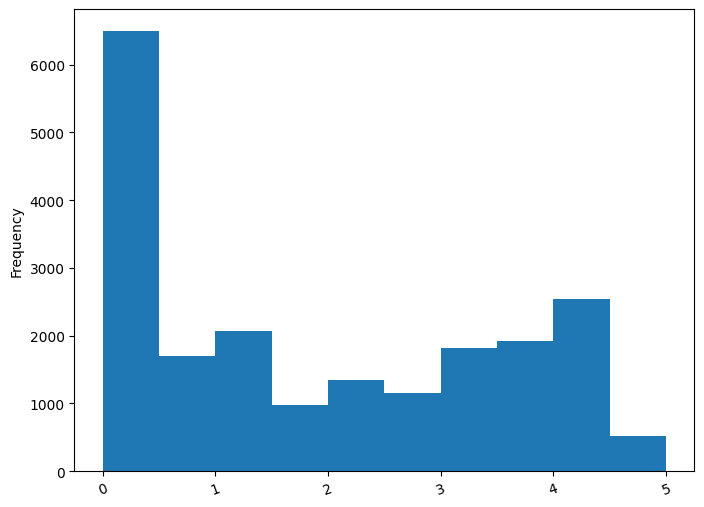

In [25]:
# label의 분포
r02_e_df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
plt.show()

In [33]:
r02_e_df['label'].value_counts()[0.0]

4673

In [26]:
zero_df = r02_e_df[r02_e_df['label'] == 0]
n_df =  r02_e_df[r02_e_df['label'] != 0]
ero_df_half = zero_df.sample(frac=0.5,random_state=42)
r02_e_no_df = pd.concat([n_df,ero_df_half])
r02_e_no_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
5,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
...,...,...,...,...,...,...
6182,boostcamp-sts-v1-train-6182,nsmc-sampled,우와정말이영화있네..ㅋㅋㅋ,헐.. 아나 진짜 점수 너무하네 .,0.0,0.0
3622,boostcamp-sts-v1-train-3622,nsmc-sampled,성룡도 별로 나오지도 않고,여자도 영화도 별로...,0.0,0.0
6136,boostcamp-sts-v1-train-6136,slack-sampled,근손실 방지를 위해 의자 대신 스쾃 자세로 드시는거 아니죠?,6피스만 드신 거 아니죠?,0.0,0.0
6043,boostcamp-sts-v1-train-6043,slack-sampled,결혼 이후에는 요리에 관심이 생겨 다양한 요리에 도전하셨는데 온갖 재료로 김밥을 말...,서로 취미 생활을 공유하다가 둘 다 취미생활에 열정을 쏟는다는 공통점을 발견했습니다,0.0,0.0


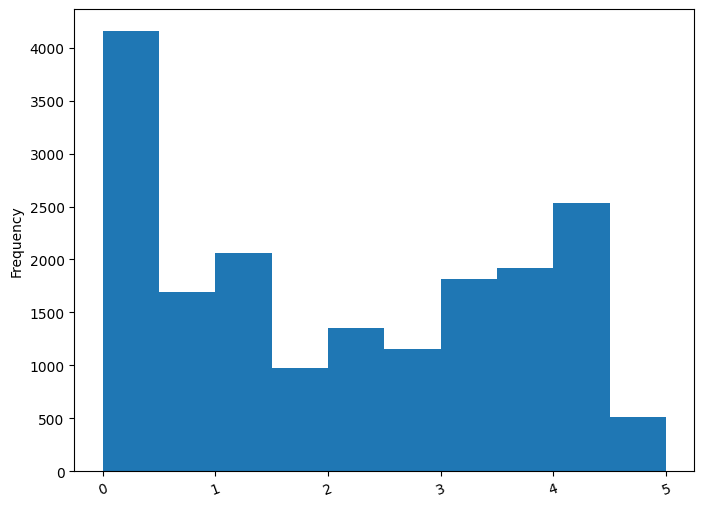

In [28]:
r02_e_no_df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
plt.show()

In [34]:
r02_e_no_df['label'].value_counts()[0.0]

2336

In [35]:
not5_df = r02_e_no_df.loc[r02_e_no_df['label']!=5.0]
tmp = not5_df.sample(frac=0.5, random_state=42)
tmp['label'] = 5.0
tmp['binary-label'] = 1.0
tmp['sentence_1'] = tmp['sentence_2']
tmp = tmp.reset_index().iloc[:,1:]
r02_e_no_c_05_df = pd.concat([r02_e_no_df,tmp]).reset_index().iloc[:,1:]
r02_e_no_c_05_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
...,...,...,...,...,...,...
27161,boostcamp-sts-v1-train-8307,nsmc-sampled,에휴 진짜 삼류영화,에휴 진짜 삼류영화,5.0,1.0
27162,boostcamp-sts-v1-train-2565,nsmc-sampled,무작정 짐싸들고 바다로 가고 싶은 기분.,무작정 짐싸들고 바다로 가고 싶은 기분.,5.0,1.0
27163,boostcamp-sts-v1-train-6547,petition-rtt,국회의원 최저시급 및 활동비 제한해주세요,국회의원 최저시급 및 활동비 제한해주세요,5.0,1.0
27164,boostcamp-sts-v1-train-5096,petition-sampled,자격없다 금감원장 김기식은,자격없다 금감원장 김기식은,5.0,1.0


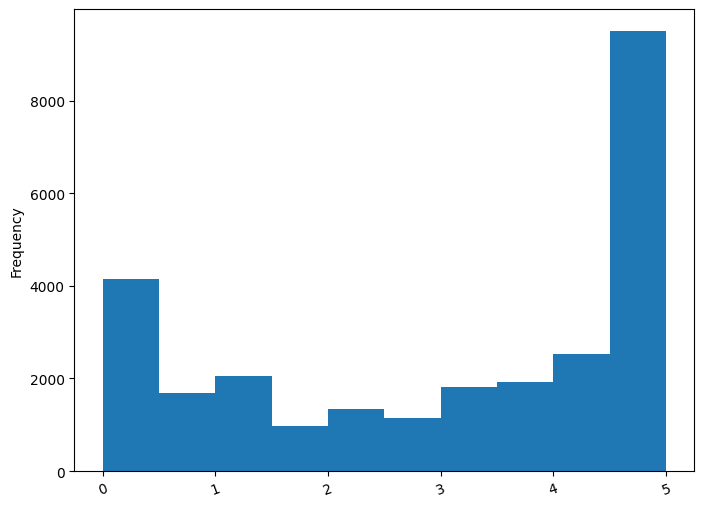

In [36]:
r02_e_no_c_05_df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
plt.show()

In [50]:
r02_e_no_c_05_df.to_csv(path_or_buf=address+'r02_e_no_c_05_df.csv', index=False)

In [42]:
e_df = pd.read_csv("./data/e_df.csv")
e_df = e_df.iloc[:,1:]

In [44]:
e_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
18643,boostcamp-sts-v1-train-9319,petition-sampled,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
18644,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드,4.2,1.0
18645,boostcamp-sts-v1-train-9321,petition-sampled,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요,0.6,0.0
18646,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,3.2,1.0


In [43]:
zero_df = e_df[e_df['label'] == 0]
n_df =  e_df[e_df['label'] != 0]
ero_df_half = zero_df.sample(frac=0.5,random_state=42)
e_no_df = pd.concat([n_df,ero_df_half])
e_no_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
5,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
...,...,...,...,...,...,...
11903,boostcamp-sts-v1-train-2579,petition-sampled,여름철 적정 실내온도를 24~25도로 낮춰주세요.,수도권지하철요금을 옛날1150원으로 바꿔주세요,0.0,0.0
2920,boostcamp-sts-v1-train-2920,nsmc-sampled,후반의 하니 노래 우려먹기 약간은 애교로 봐줄 수 있음,출연배우들의 발연기를 실컷 볼 수 있음,0.0,0.0
5143,boostcamp-sts-v1-train-5143,slack-sampled,"로컬스티치! 라는 공유오피스가 있는데 곧 신사, 가로수길점이 생간다고 들었어요!!",근처에 “앤더스 제주” 라는 카페도 넘 좋았어요!!!,0.0,0.0
8550,boostcamp-sts-v1-train-8550,slack-sampled,아.. 진짜 한 십년 지난 듯한 기분이,하아... 정말 마음 사르르 녹는 영상이네요...,0.0,0.0


In [45]:
not5_df = e_no_df.loc[e_no_df['label']!=5.0]
tmp = not5_df.sample(frac=0.5, random_state=42)
tmp['label'] = 5.0
tmp['binary-label'] = 1.0
tmp['sentence_1'] = tmp['sentence_2']
tmp = tmp.reset_index().iloc[:,1:]
e_no_c_05_df = pd.concat([e_no_df,tmp]).reset_index().iloc[:,1:]
e_no_c_05_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
...,...,...,...,...,...,...
24698,boostcamp-sts-v1-train-5104,slack-sampled,오.. 집 분위기랑 매우 어울려요..,오.. 집 분위기랑 매우 어울려요..,5.0,1.0
24699,boostcamp-sts-v1-train-7117,nsmc-sampled,"평점왜저래높노,,,,,","평점왜저래높노,,,,,",5.0,1.0
24700,boostcamp-sts-v1-train-7252,petition-rtt,"전시작전권 전환, 병역감축, 군복무기간 단축 반대청원","전시작전권 전환, 병역감축, 군복무기간 단축 반대청원",5.0,1.0
24701,boostcamp-sts-v1-train-3015,nsmc-rtt,갑갑한 마음에 한순만 쉬었던 영화 작품성 배우연기력 몰입도 결론 잊고 싶은영화,갑갑한 마음에 한순만 쉬었던 영화 작품성 배우연기력 몰입도 결론 잊고 싶은영화,5.0,1.0


# result

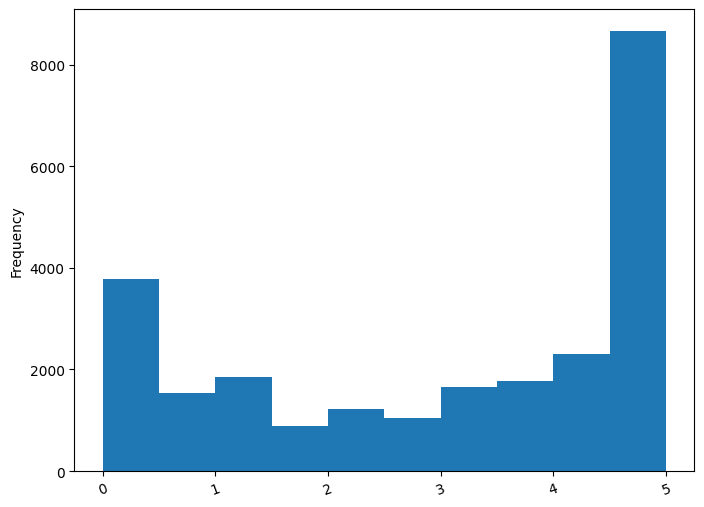

In [46]:
e_no_c_05_df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
plt.show()

In [49]:
e_no_c_05_df.to_csv(path_or_buf=address+'e_no_c_05_df.csv', index=False)

In [48]:
ls

code/  data/  e_re25_df.csv  lightning_logs/  output/  result/  sts/  wandb/


In [51]:
cd result

/opt/ml/result


In [52]:
ls

output_10280151.csv


In [55]:
res = pd.read_csv('output_10280151.csv')

In [56]:
res

,id,target
0,boostcamp-sts-v1-test-000,4.2
1,boostcamp-sts-v1-test-001,4.6
2,boostcamp-sts-v1-test-002,3.0
3,boostcamp-sts-v1-test-003,0.1
4,boostcamp-sts-v1-test-004,4.3
...,...,...
1095,boostcamp-sts-v1-test-1095,1.6
1096,boostcamp-sts-v1-test-1096,4.7
1097,boostcamp-sts-v1-test-1097,4.2
1098,boostcamp-sts-v1-test-1098,4.5


<AxesSubplot:ylabel='Frequency'>

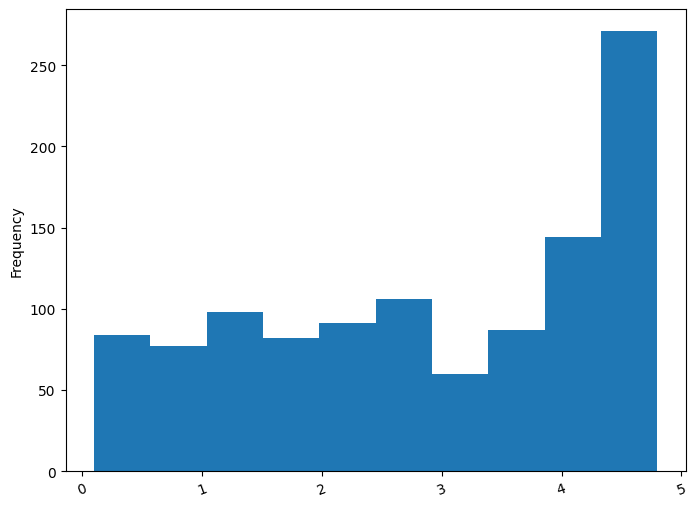

In [57]:
res['target'].plot(kind='hist', rot=20, figsize=(8, 6))

# dev

# binary label 기준 나눠서 돌리기

In [9]:
e_no_c_05_df = pd.read_csv('e_no_c_05_df.csv')

In [10]:
e_no_c_05_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
...,...,...,...,...,...,...
24698,boostcamp-sts-v1-train-5104,slack-sampled,오.. 집 분위기랑 매우 어울려요..,오.. 집 분위기랑 매우 어울려요..,5.0,1.0
24699,boostcamp-sts-v1-train-7117,nsmc-sampled,"평점왜저래높노,,,,,","평점왜저래높노,,,,,",5.0,1.0
24700,boostcamp-sts-v1-train-7252,petition-rtt,"전시작전권 전환, 병역감축, 군복무기간 단축 반대청원","전시작전권 전환, 병역감축, 군복무기간 단축 반대청원",5.0,1.0
24701,boostcamp-sts-v1-train-3015,nsmc-rtt,갑갑한 마음에 한순만 쉬었던 영화 작품성 배우연기력 몰입도 결론 잊고 싶은영화,갑갑한 마음에 한순만 쉬었던 영화 작품성 배우연기력 몰입도 결론 잊고 싶은영화,5.0,1.0


In [11]:
e_no_c_05_df[e_no_c_05_df['binary-label'] == 0.0]

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
6,boostcamp-sts-v1-train-007,nsmc-sampled,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..,0.6,0.0
7,boostcamp-sts-v1-train-008,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!!,0.4,0.0
9,boostcamp-sts-v1-train-010,slack-rtt,그 책부터 언능 꺼내봐야 겠어요!,책에서 꺼내야겠어요!,2.4,0.0
...,...,...,...,...,...,...
16524,boostcamp-sts-v1-train-2579,petition-sampled,여름철 적정 실내온도를 24~25도로 낮춰주세요.,수도권지하철요금을 옛날1150원으로 바꿔주세요,0.0,0.0
16525,boostcamp-sts-v1-train-2920,nsmc-sampled,후반의 하니 노래 우려먹기 약간은 애교로 봐줄 수 있음,출연배우들의 발연기를 실컷 볼 수 있음,0.0,0.0
16526,boostcamp-sts-v1-train-5143,slack-sampled,"로컬스티치! 라는 공유오피스가 있는데 곧 신사, 가로수길점이 생간다고 들었어요!!",근처에 “앤더스 제주” 라는 카페도 넘 좋았어요!!!,0.0,0.0
16527,boostcamp-sts-v1-train-8550,slack-sampled,아.. 진짜 한 십년 지난 듯한 기분이,하아... 정말 마음 사르르 녹는 영상이네요...,0.0,0.0
